# pythia-features

In [1]:
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import utils, stats
%matplotlib widget

In [2]:
# Knobs
#data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features.csv' # Max pooling
data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree1.csv' # Max pooling, degree 1
#data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_sum.csv' # Sum pooling
baseline_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_baseline.csv'

seed = 1337
output_dir = './plots/pythia_features'
suites = {
    'SPEC 06': utils.spec06,
    #'SPEC 17': utils.spec17,
    #'GAP': utils.gap,
}
metrics  = [
    'ipc_improvement', 
    'L2C_issued_prefetches', 
    #'L2C_mpki_reduction', 
    'L2C_accuracy', 
    'L2C_coverage'
]
features = [
    # --- Current graphs ---
    {'Delta_Path', 'PC_Delta'},
    {'PC'},
    {'PC_Delta'},
    {'Delta_Path'},
    {'Address'},
    {'Delta'},
    {'Offset'},
    {'Page'}
    # --- Old graphs ---
    # {'Delta_Path'},
    # {'Delta_Path', 'PC_Delta'},
    # {'PC'},
    # {'PC', 'Delta_Path', 'PC_Delta'},
    # {'PC', 'PC_Address', 'Delta_Path', 'PC_Delta'},
    # {'PC', 'PC_Address', 'PC_Delta'},
    # {'PC', 'PC_Delta'},
    # {'PC_Delta'}
]

dpi = None# 120
figsize = (9, 5)

# Helper functions
- Load stats `.csv`s
- Plot single graphs
- Plot groups of graphs, by suite and metric

In [3]:
def load_data(data_path: str, feature_sets: List[str] = []) \
    -> Dict[str, pd.DataFrame]:
    """Load different feature groupings, as stored in a .csv file 
    generated from the evaluate script in Pythia/experiments.
    """
    string_to_set = lambda r : set(eval(r)) # Convert string/tuple to unordered set.
    set_to_string = lambda s : ', '.join(f for f in sorted(s)) # Convert set to string.
    data_df = {}
    df = utils.read_data_file(data_path)
    df = df[df.seed == seed]
    if feature_sets == []:
        feature_sets = df.pythia_features.unique()
        feature_sets = [string_to_set(s) for s in feature_sets]
    for feat_set in feature_sets:
        data_df[set_to_string(feat_set)] = (
            df[df.pythia_features.apply(string_to_set) == feat_set])
    return data_df

def load_data_baseline(baseline_path, baselines: List[str] = []) \
    -> Dict[Tuple[str, ...], pd.DataFrame]:
    """Load baseline stats for the baseline analysis.
    """
    base_stats_df = utils.read_data_file(baseline_path)
    base_stats_df = base_stats_df[base_stats_df.seed == seed]
    base_stats_df.fillna(0, inplace=True)

    base_dfs = {}
    if baselines == []:
        baselines = base_stats_df.L2C_pref.unique()
    for pf in baselines:
        base_dfs[pf] = base_stats_df[base_stats_df.all_pref == ('no', pf, 'no')]
    return base_dfs

In [4]:
def plot_metric(dfs: dict, metric: str, dpi: int = None, 
                figsize: Tuple[int, int] = None, suite_name: str = ''):
    """Plot the metric between the dfs on each trace in a suite.
    """
    match_prefetcher = lambda x : x != ('no', 'no', 'no') # Used in p_samples
    
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    num_samples = len(dfs.items())
    gap = num_samples + 1

    traces = list(list(dfs.values())[0].trace.unique())
    trace_names = traces + (['amean'] if metric in utils.amean_metrics else ['gmean'])
    traces = traces + ['mean']

    largest_y = 0
    for i, (setup, df) in enumerate(dfs.items()):
        df = df[df.pythia_level_threshold == float('-inf')]
        df = stats.add_means(df) # Add mean as an extra trace
        for j, tr in enumerate(traces):
            rows = df[df.trace == tr]
            pos = (gap * j) + i
            #print(f'[DEBUG] i={i} j={j} setup={setup} tr={tr} pos={pos}, {pos+1}')
            p_samples = (rows[rows.all_pref.apply(match_prefetcher)][metric])
            #p_min = p_samples.min()
            p_mean = p_samples.mean(), 
            p_max = p_samples.max()
            largest_y = max(largest_y, p_max)
            
            #print(f'[DEBUG] {tr} Regular {setup} {p_mean:.2f} {p_min:.2f} {p_max:.2f}')
            ax.bar(pos, p_mean, 
                   label=f'{setup}' if j == 0 else None, 
                   color=f'C{i}')
            # ax.errorbar(pos, p_mean, 
            #             yerr=[[p_mean - p_min], [p_max - p_mean]], 
            #             color='black')

    ax.set_xticks(np.arange(0, len(df.trace.unique())) * gap + (num_samples/2))
    ax.set_xticklabels(trace_names, rotation=90)
    ax.set_xlabel('Trace')

    # Set ticks based on metric
    if any(s in metric for s in ['ipc_improvement', 'accuracy', 'coverage', 'mpki_reduction']):
        #largest_y = 150
        ax.set_yticks(np.arange(0, round(largest_y, -1) + 10, 10))

    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
        
    fig.legend() #bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    fig.suptitle(f'{metric.replace("_", " ")} ({suite_name})')
    fig.tight_layout()

In [5]:
def plot_everything(data_df: Dict[str, pd.DataFrame],
                    suites: Dict[str, List[str]] = {'SPEC 06': utils.spec06},
                    metrics: List[str] = ['ipc_improvement']):
    """Plot across multiple suites and metrics."""
    for suite_name, suite in suites.items():
        data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
        print(suite_name)
        for metric in metrics: 
            plot_metric(data_df_, metric, 
                        suite_name=suite_name, figsize=figsize, dpi=dpi)
            plt.show()

# Pythia Features
Compare different Pythia features on different metrics. We see a greater difference when dynamic degree is disabled.

SPEC 06


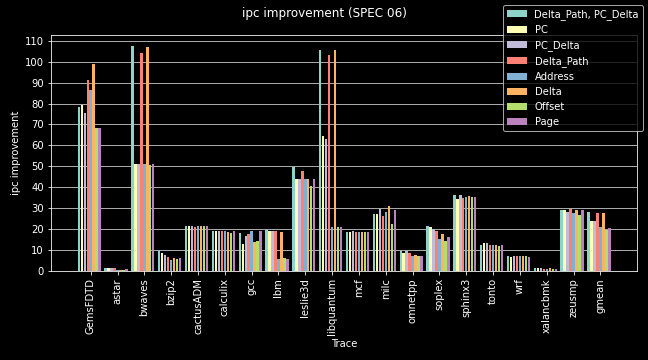

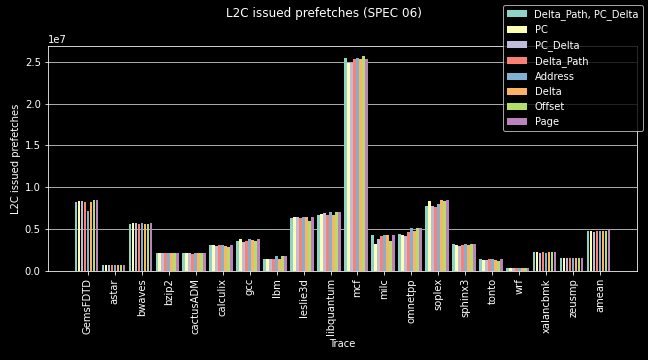

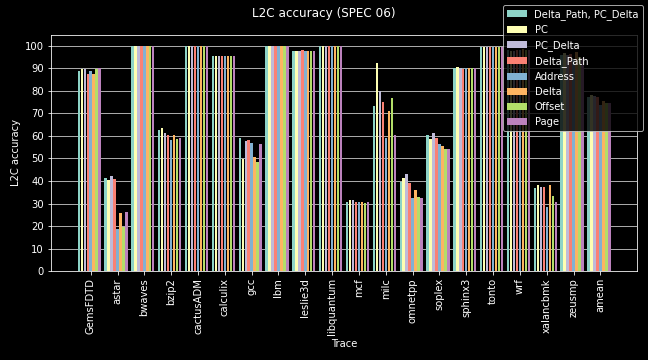

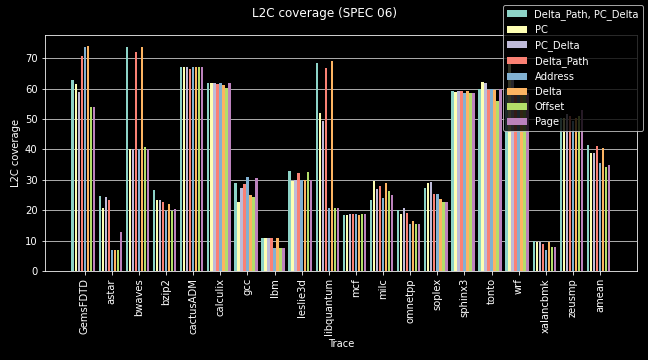

In [6]:
data_df : dict = load_data(data_path, feature_sets=features)
plot_everything(data_df, suites=suites, metrics=metrics)

# Baselines
Fix prefetch degree, and compare to Bingo, SPP and Bingo+SPP hybrid

TODO: Should Bingo and SPP be allowed to prefetch into LLC (instead of L2)? Banning this would reduce their IPC improvement, but give more apples-to-apples L2 accuracy/coverage stats.

In [ ]:
pythia_deg1_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree1.csv' # Max pooling, degree 1
pythia_deg2_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree2.csv' # Max pooling, degree 1

pythia_deg1_df = load_data(pythia_deg1_path, feature_sets=[{'PC_Delta'}, {'Delta_Path'}])
pythia_deg2_df = load_data(pythia_deg2_path, feature_sets=[{'PC_Delta', 'Delta_Path'}])
baseline_df = load_data_baseline(baseline_path, baselines=['bingo', 'spp', 'bingo_spp'])

## Pythia vs. everything (degree 1/2)

In [ ]:
compare_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg2_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path)': pythia_deg1_df['Delta_Path'],
    'Pythia (PC_Delta)': pythia_deg1_df['PC_Delta'],
    'Bingo+SPP': baseline_df['bingo_spp'],
    'SPP': baseline_df['spp'],
    'Bingo': baseline_df['bingo'],
}
plot_everything(compare_df, suites=suites, metrics=metrics)


## Pythia vs. SPP (degree 1)

In [ ]:
compare_df = {
    'Pythia (Delta_Path)': pythia_deg1_df['Delta_Path'],
    'SPP': baseline_df['spp'],
}
plot_everything(compare_df, suites=suites, metrics=metrics)

## Pythia vs. Bingo (degree 1)

In [ ]:
compare_df = {
    'Pythia (PC_Delta)': pythia_deg1_df['PC_Delta'],
    'Bingo': baseline_df['bingo'],
}
plot_everything(compare_df, suites=suites, metrics=metrics)

## Pythia vs. SPP+Bingo (degree 2)

Specifically, Bingo and SPP are at degree 1 each, and Pythia is at degree 2.

In [ ]:
bingo_spp_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg2_df['Delta_Path, PC_Delta'],
    'Bingo+SPP': baseline_df['bingo_spp']
}
plot_everything(bingo_spp_df, suites=suites, metrics=metrics)